# Dynamics

In the previous tutorials we created Atoms objects and used Calculators to get properties including energies and forces... but we didn't do very much with this information.

A very useful thing to do with this information is to update our strucuture! ASE includes algorithms for molecular dynamics, geometry optimization and global optimization. It is a useful toolkit for experimentation and method-development in this area, or development of multi-step pipelines.

## Molecular dynamics

Molecular dynamics (MD) methods are found in [ase.md](https://wiki.fysik.dtu.dk/ase/ase/md.html).

> This is not a course in MD; be aware that thermostats and timesteps should be chosen with care for a given research problem!

Starting with the EMT potential, let us try some simulated annealing of a cubic Cu nanoparticle. First we prepare the structure and assign some initial momenta.

In [1]:
import ase.build
from ase.calculators.emt import EMT
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution

# Set up a crystal
cu_cube = ase.build.bulk('Cu', cubic=True) * [3, 3, 3]

# Describe the interatomic interactions with the Effective Medium Theory
cu_cube.calc = EMT()

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(cu_cube, temperature_K=300)

There are stores on the atoms as velocities. The initial forces should be very small due to symmetry.

In [2]:
row_limit = 4
print('velocities:')
print(cu_cube.get_velocities()[:row_limit])

print('\nforces:')
print(cu_cube.get_forces()[:row_limit])

print(f'\nkinetic energy: {cu_cube.get_kinetic_energy()}')

velocities:
[[ 0.04415792 -0.04196006 -0.02130616]
 [ 0.00674007 -0.009692    0.02499719]
 [ 0.00949497 -0.00967576  0.03271635]
 [ 0.01499601 -0.01203037 -0.02456846]]

forces:
[[ 1.05748743e-14  9.68843061e-15  8.49667559e-15]
 [ 2.47839943e-14 -1.35655376e-15 -2.27769192e-15]
 [-1.81799020e-15  1.80896964e-14 -1.32012457e-15]
 [-2.18835366e-15  1.32706346e-16  1.38292156e-14]]

kinetic energy: 5.209391647215017


Next the dynamics object is created and the Atoms are attached to it. For constant-energy MD we can use the Velocity Verlet method.

While the default distance and energy units (Angstrom and eV) in ASE are fairly friendly, the related time unit is a bit awkward so we use a unit conversion from `ase.units` to set a timestep of 5 fs.

In [3]:
from ase import units
from ase.md.verlet import VelocityVerlet

dyn = VelocityVerlet(cu_cube, 5 * units.fs)

dyn.run(1)


print('velocities:')
print(cu_cube.get_velocities()[:row_limit])

print('\nforces:')
print(cu_cube.get_forces()[:row_limit])

velocities:
[[ 0.04342004 -0.04111118 -0.02074165]
 [ 0.00662474 -0.01022957  0.02452406]
 [ 0.00927404 -0.00939438  0.03250037]
 [ 0.01462945 -0.01201408 -0.02386139]]

forces:
[[-0.19094268  0.21966678  0.14607907]
 [-0.02984384 -0.13910846 -0.12243429]
 [-0.05717046  0.07281418 -0.05589085]
 [-0.09485569  0.00421554  0.18297141]]


After one timestep, we see that the velocities have changes slightly and significant forces have appeared.
Running some more time steps, while occasionally printing the kinetic and potential energy:

In [4]:
from ase import Atoms
def printenergy(atoms: Atoms) -> None:
    """Function to print the potential, kinetic and total energy"""
    epot = atoms.get_potential_energy() / len(atoms)
    ekin = atoms.get_kinetic_energy() / len(atoms)
    temperature = ekin / (1.5 * units.kB)
    
    print(f'Energy per atom: Epot = {epot:.3f}eV  Ekin = {ekin:.3f}eV '
          f'(T={temperature:3.0f}K)  Etot = {epot+ekin:.3f}eV')

# Now run the dynamics
printenergy(cu_cube)
for i in range(20):
    dyn.run(10)
    printenergy(cu_cube)

Energy per atom: Epot = -0.004eV  Ekin = 0.047eV (T=362K)  Etot = 0.043eV
Energy per atom: Epot = 0.028eV  Ekin = 0.015eV (T=115K)  Etot = 0.043eV
Energy per atom: Epot = 0.020eV  Ekin = 0.023eV (T=175K)  Etot = 0.043eV
Energy per atom: Epot = 0.019eV  Ekin = 0.024eV (T=186K)  Etot = 0.043eV
Energy per atom: Epot = 0.012eV  Ekin = 0.031eV (T=239K)  Etot = 0.043eV
Energy per atom: Epot = 0.020eV  Ekin = 0.022eV (T=174K)  Etot = 0.043eV
Energy per atom: Epot = 0.023eV  Ekin = 0.020eV (T=151K)  Etot = 0.043eV
Energy per atom: Epot = 0.013eV  Ekin = 0.029eV (T=228K)  Etot = 0.043eV
Energy per atom: Epot = 0.022eV  Ekin = 0.021eV (T=159K)  Etot = 0.043eV
Energy per atom: Epot = 0.016eV  Ekin = 0.027eV (T=206K)  Etot = 0.043eV
Energy per atom: Epot = 0.018eV  Ekin = 0.025eV (T=194K)  Etot = 0.043eV
Energy per atom: Epot = 0.021eV  Ekin = 0.022eV (T=169K)  Etot = 0.043eV
Energy per atom: Epot = 0.019eV  Ekin = 0.023eV (T=180K)  Etot = 0.043eV
Energy per atom: Epot = 0.011eV  Ekin = 0.032eV (T

As the system equilibrates, energy is conserved but the temperature is about half of the original setting. *Why?*

It's a bit inconvenient to write a loop that stops and starts the MD as above; instead we can attach an "observer" function.

In [5]:
# Run a few more steps
def energy_observer():
    printenergy(cu_cube)
    
dyn.attach(energy_observer, interval=10)
dyn.run(100)

Energy per atom: Epot = 0.020eV  Ekin = 0.022eV (T=173K)  Etot = 0.043eV
Energy per atom: Epot = 0.017eV  Ekin = 0.026eV (T=200K)  Etot = 0.043eV
Energy per atom: Epot = 0.020eV  Ekin = 0.022eV (T=174K)  Etot = 0.043eV
Energy per atom: Epot = 0.017eV  Ekin = 0.026eV (T=200K)  Etot = 0.043eV
Energy per atom: Epot = 0.019eV  Ekin = 0.024eV (T=185K)  Etot = 0.043eV
Energy per atom: Epot = 0.017eV  Ekin = 0.026eV (T=199K)  Etot = 0.043eV
Energy per atom: Epot = 0.021eV  Ekin = 0.022eV (T=167K)  Etot = 0.043eV
Energy per atom: Epot = 0.015eV  Ekin = 0.027eV (T=212K)  Etot = 0.043eV
Energy per atom: Epot = 0.019eV  Ekin = 0.023eV (T=180K)  Etot = 0.043eV
Energy per atom: Epot = 0.018eV  Ekin = 0.025eV (T=192K)  Etot = 0.043eV


True

**Exercise:** use an observer to measure the average (root mean-square) displacement of Cu atoms at 300K

In [6]:
import nglview

def show(atoms: ase.Atoms) -> None:
    view = nglview.show_ase(atoms)
    if any(atoms.pbc):
        view.add_unitcell()
    return view

show(cu_cube)

NGLWidget()

At modest temperature and under periodic boundary conditions, the atoms have not moved very far. Let's try something more extreme: remove the boundary conditions, ramp up the temperature, and use a Langevin thermostat that regulates the temperature. This will take a few minutes to run.

In [7]:
from ase.io.trajectory import Trajectory
from ase.md import Langevin

cu_lump = cu_cube.copy()
cu_lump.pbc=False
cu_lump.calc = EMT()

def energy_observer():
    printenergy(cu_lump)

dyn = Langevin(cu_lump, 5 * units.fs, friction=0.005, temperature_K=1000)
dyn.attach(energy_observer, interval=50)

# We also want to save the positions of all atoms after every 50th time step.
traj = Trajectory('cu_melt.traj', 'w', cu_lump)
dyn.attach(traj.write, interval=50)

# Now run the dynamics
dyn.run(1000)


Energy per atom: Epot = 0.458eV  Ekin = 0.025eV (T=193K)  Etot = 0.483eV
Energy per atom: Epot = 0.463eV  Ekin = 0.042eV (T=322K)  Etot = 0.504eV
Energy per atom: Epot = 0.477eV  Ekin = 0.048eV (T=372K)  Etot = 0.525eV
Energy per atom: Epot = 0.496eV  Ekin = 0.058eV (T=452K)  Etot = 0.554eV
Energy per atom: Epot = 0.493eV  Ekin = 0.070eV (T=539K)  Etot = 0.562eV
Energy per atom: Epot = 0.504eV  Ekin = 0.076eV (T=587K)  Etot = 0.580eV
Energy per atom: Epot = 0.507eV  Ekin = 0.085eV (T=661K)  Etot = 0.592eV
Energy per atom: Epot = 0.518eV  Ekin = 0.080eV (T=617K)  Etot = 0.598eV
Energy per atom: Epot = 0.511eV  Ekin = 0.095eV (T=732K)  Etot = 0.606eV
Energy per atom: Epot = 0.526eV  Ekin = 0.090eV (T=694K)  Etot = 0.616eV
Energy per atom: Epot = 0.517eV  Ekin = 0.106eV (T=821K)  Etot = 0.623eV
Energy per atom: Epot = 0.543eV  Ekin = 0.099eV (T=763K)  Etot = 0.642eV
Energy per atom: Epot = 0.551eV  Ekin = 0.094eV (T=724K)  Etot = 0.644eV
Energy per atom: Epot = 0.539eV  Ekin = 0.110eV (T=

True

The trajectory file lets us visualise what happened.

In [8]:
from ase.visualize import view
import ase.io

frames = ase.io.read('cu_melt.traj', index=':')
view(frames)

<Popen: returncode: None args: ['/home/adamjackson/mambaforge/envs/ase-tutor...>

Having reached temperature we can also steadily quench by reducing the target temperature over the course of the simulation.

In [9]:
for temperature in range(800, 100, -50):
    dyn.set_temperature(temperature_K=temperature)
    dyn.run(100)

Traceback (most recent call last):
  File "/home/adamjackson/mambaforge/envs/ase-tutorial/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/adamjackson/mambaforge/envs/ase-tutorial/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/adamjackson/opt/ase-fork/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/home/adamjackson/opt/ase-fork/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/home/adamjackson/mambaforge/envs/ase-tutorial/lib/python3.10/site-packages/matplotlib/pyplot.py", line 446, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/home/adamjackson/mambaforge/envs/ase-tutorial/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/home/adamjackson/mambaforge/envs/ase-tutorial/lib/python3.10/site-packages/IPython/core/display_functions.py", line 265, in display
    print(*objs)
ValueErr

Energy per atom: Epot = 0.573eV  Ekin = 0.113eV (T=877K)  Etot = 0.687eV
Energy per atom: Epot = 0.571eV  Ekin = 0.105eV (T=815K)  Etot = 0.676eV
Energy per atom: Epot = 0.564eV  Ekin = 0.116eV (T=898K)  Etot = 0.680eV
Energy per atom: Epot = 0.559eV  Ekin = 0.116eV (T=897K)  Etot = 0.675eV
Energy per atom: Epot = 0.569eV  Ekin = 0.100eV (T=776K)  Etot = 0.670eV
Energy per atom: Epot = 0.560eV  Ekin = 0.105eV (T=816K)  Etot = 0.665eV
Energy per atom: Epot = 0.541eV  Ekin = 0.114eV (T=883K)  Etot = 0.655eV
Energy per atom: Epot = 0.549eV  Ekin = 0.098eV (T=760K)  Etot = 0.648eV
Energy per atom: Epot = 0.534eV  Ekin = 0.106eV (T=823K)  Etot = 0.641eV
Energy per atom: Epot = 0.527eV  Ekin = 0.101eV (T=785K)  Etot = 0.629eV
Energy per atom: Epot = 0.534eV  Ekin = 0.094eV (T=728K)  Etot = 0.628eV
Energy per atom: Epot = 0.529eV  Ekin = 0.090eV (T=695K)  Etot = 0.619eV
Energy per atom: Epot = 0.538eV  Ekin = 0.080eV (T=615K)  Etot = 0.618eV
Energy per atom: Epot = 0.533eV  Ekin = 0.079eV (T=

In [10]:
frames = ase.io.read('cu_melt.traj', index=':')
view(frames)

<Popen: returncode: None args: ['/home/adamjackson/mambaforge/envs/ase-tutor...>

We see that as the temperature falls some order returns to the structure.

# Local optimisation

With a zero temperature thermostat we would eventually expect the structure to reach some local minimum energy in the potential-energy surface. Generally it is more efficient to achieve this by a dedicated "geometry optimisation" algorithm that seeks to minimise energy and forces.

Let's grab a molecular structure and apply a semi-empirical potential.

In [11]:
from ase.calculators.mopac import MOPAC

In [12]:
atoms = ase.build.molecule('CH3CH2OH')
atoms.calc = MOPAC()
atoms.get_forces()



          MOPAC Job: "mopac.mop" ended normally on Apr 17, 2023, at 11:15.



array([[ 0.05314722, -0.14217078,  0.        ],
       [ 0.08516519,  0.2916233 ,  0.        ],
       [ 0.46667555,  0.31685049,  0.        ],
       [-0.30313837, -0.04753196,  0.        ],
       [-0.29917533,  0.04623103,  0.23729349],
       [-0.2992056 ,  0.04519975, -0.23729349],
       [ 0.11622196, -0.06459161,  0.        ],
       [ 0.09013888, -0.22333767,  0.08025091],
       [ 0.09017054, -0.22227256, -0.08025091]])

We can see from the forces that this potential does not quite agree with the structure from the G2 database. For further analysis we would like to find the local minimum. ASE provides a range of algorthms in the `ase.optimize` module.

In [13]:
from ase.optimize import GPMin
# To avoid that "ended normally" message on every step, we
# tweak the command a bit
atoms.calc = MOPAC(command='mopac PREFIX.mop 1> /dev/null')
opt = GPMin(atoms)
opt.run(fmax=1e-3)

       Step     Time          Energy          fmax
GPMin:    0 11:15:28       -2.385274         0.564075
GPMin:    1 11:15:28       -2.392905         1.033572
GPMin:    2 11:15:28       -2.403956         0.742120
GPMin:    3 11:15:28       -2.420694         0.221260
GPMin:    4 11:15:28       -2.421733         0.151170
GPMin:    5 11:15:28       -2.422788         0.015994
GPMin:    6 11:15:28       -2.422797         0.010651
GPMin:    7 11:15:28       -2.422799         0.006327
GPMin:    8 11:15:28       -2.422801         0.003863
GPMin:    9 11:15:28       -2.422801         0.000485


Traceback (most recent call last):
  File "/home/adamjackson/mambaforge/envs/ase-tutorial/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/adamjackson/mambaforge/envs/ase-tutorial/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/adamjackson/opt/ase-fork/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/home/adamjackson/opt/ase-fork/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/home/adamjackson/mambaforge/envs/ase-tutorial/lib/python3.10/site-packages/matplotlib/pyplot.py", line 446, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/home/adamjackson/mambaforge/envs/ase-tutorial/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/home/adamjackson/mambaforge/envs/ase-tutorial/lib/python3.10/site-packages/IPython/core/display_functions.py", line 265, in display
    print(*objs)
ValueErr

True

> Note that this mutates the original atoms object and updates its positions.

In [14]:
atoms.get_forces()

array([[ 7.17242279e-05,  1.52121276e-04, -2.75015147e-04],
       [ 2.59490798e-04,  9.01106079e-05,  4.03286166e-06],
       [-4.31949839e-04, -1.41150158e-04,  1.70377564e-04],
       [ 1.22850506e-04, -3.39324113e-04,  3.42142780e-05],
       [-6.14902993e-05,  4.04153448e-05, -5.03023605e-05],
       [-1.96786304e-04, -1.73499780e-04, -1.32824250e-04],
       [ 1.40066056e-05,  1.05244680e-04,  2.27704910e-04],
       [-3.03548727e-05, -6.07097455e-05,  8.32590795e-06],
       [ 2.52552541e-04,  3.26878615e-04,  1.34862363e-05]])

**Exercise: compare the performance of QuasiNewton, FIRE and GPMin optimizers for a few small organic molecules**

## Constraints

We don't always want to optimize every degree of freedom; perhaps we can assume some region is rigid, or we are using a forcefield that fixes some bond length. In ASE this is achieved by applying _constraints_ to the Atoms object before optimisation.

Suppose we want to explore the effect of stretching the C-C bond in ethane, while allowing the hydrogen atoms to relax to their local minimum at each configuration.

In [15]:
from ase.constraints import FixAtoms

ethane = ase.build.molecule('C2H6')
g2_c_c = ethane.positions[1, 2] - ethane.positions[0, 2]
constraint = FixAtoms(mask=(atoms.symbols == 'C'))

def build_stretched_ethane(d: float = g2_c_c) -> Atoms:
    shift = (d - g2_c_c) / 2
    ethane = ase.build.molecule('C2H6')
    ethane.positions[[0, 2, 3, 4]] += [0, 0, shift]
    ethane.positions[[1, 5, 6, 7]] -= [0, 0, shift]
    ethane.set_constraint(constraint)
    return ethane

def get_optimised_energy(atoms: Atoms) -> float:
    # Redirect STDOUT to avoid annoying message on every step
    atoms.calc = MOPAC(command='mopac PREFIX.mop 1> /dev/null')
    opt = GPMin(atoms)
    opt.run(fmax=1e-3)
    return atoms.get_potential_energy()

In [16]:
import numpy as np
lengths = np.linspace(0.8, 1.04, 10) * g2_c_c
energies = [get_optimised_energy(build_stretched_ethane(d)) for d in lengths]


       Step     Time          Energy          fmax
GPMin:    0 11:15:29        0.208544         0.693187
GPMin:    1 11:15:29        0.010296         0.115406
GPMin:    2 11:15:29        0.008034         0.024697
GPMin:    3 11:15:29        0.007877         0.011408
GPMin:    4 11:15:29        0.007868         0.001131
GPMin:    5 11:15:29        0.007871         0.000784
       Step     Time          Energy          fmax
GPMin:    0 11:15:29        0.004891         0.621748
GPMin:    1 11:15:29       -0.148598         0.110453
GPMin:    2 11:15:29       -0.151673         0.029460
GPMin:    3 11:15:29       -0.151831         0.010914
GPMin:    4 11:15:29       -0.151840         0.001365
GPMin:    5 11:15:30       -0.151837         0.000968
       Step     Time          Energy          fmax
GPMin:    0 11:15:30       -0.185557         0.542410
GPMin:    1 11:15:30       -0.297151         0.110753
GPMin:    2 11:15:30       -0.301405         0.033660
GPMin:    3 11:15:30       -0.301558 

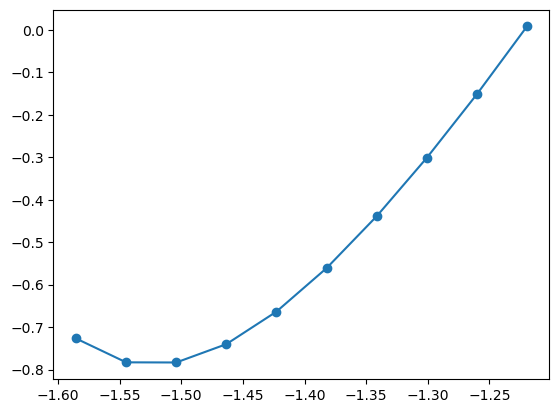

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(lengths, energies, 'o-')

## Filters

By default the geometry optimization only considers the atomic positions. To present other degrees of freedom, ASE includes "filters" that present them to the optimizer.

Suppose we want to find the minimum-energy Si lattice parameters for a GAP machine-learned potential.

In [18]:
from ase.constraints import StrainFilter

from pathlib import Path
#import quippy.potential_module
from quippy.potential import Potential

gap = Potential(param_filename=str(Path.cwd() / 'Si_PRX_GAP/gp_iter6_sparse9k.xml'))

In [19]:
si = ase.build.bulk('Si', cubic=True)
si.calc = gap
si_strain = StrainFilter(si)

The filter presents a similar interface to Atoms, but "cheats" and puts different information into the positions data; in this case a strain relative to the initial unit cell.

In [20]:
si_strain.get_positions()

array([[0., 0., 0.],
       [0., 0., 0.]])

In this case the calculated stresses are then remapped to "atomic forces"

In [21]:
si_strain.get_forces()

array([[ 1.55837119e+00,  1.55837119e+00,  1.55837119e+00],
       [ 7.06032455e-16, -6.41847686e-17, -8.67361738e-18]])

In [22]:
from ase.optimize import QuasiNewton
opt = QuasiNewton(si_strain)
opt.run(fmax=1e-4)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 11:15:35    -1305.407858*       2.6992
BFGSLineSearch:    1[  2] 11:15:36    -1305.420818*       0.3445
BFGSLineSearch:    2[  3] 11:15:36    -1305.421038*       0.0080
BFGSLineSearch:    3[  4] 11:15:36    -1305.421038*       0.0000


True

This gets us a Si lattice with very low stress:

In [23]:
print(f"Lattice parameter: {si.cell.lengths()[0]}")
print("Residual stress:")
print(si.get_stress())

Lattice parameter: 5.460914996056226
Residual stress:
[-8.62027513e-08 -8.62027472e-08 -8.62027630e-08 -2.58637937e-15
 -6.90550987e-15 -4.46639070e-15]


We can optimise the lattice vectors and positions at the same time using a [UnitCellFilter](https://wiki.fysik.dtu.dk/ase/ase/constraints.html#the-unitcellfilter-class) or the more sophisticated [ExpCellFilter](https://wiki.fysik.dtu.dk/ase/ase/constraints.html#the-expcellfilter-class).

Let's generate an amorphous Si cell by stretching a supercell and running a few steps of high-temperature MD. This is a similar process to the Cu calculation, but now we are keeping the periodic boundary and using a machine-learned potential. It should take a few minutes to run.

In [24]:
si = ase.build.bulk('Si', cubic=True) * [2, 2, 2]
si.set_cell(si.cell * 1.2, scale_atoms=True)
si.calc = gap
si.calc.name = 'Si melt'

In [25]:
MaxwellBoltzmannDistribution(si, temperature_K=3000)
dyn = Langevin(si, 5 * ase.units.fs, friction=0.002, temperature_K=3000)
dyn.attach(energy_observer, interval=20)
traj = Trajectory('si_melt.traj', 'w', si)
dyn.attach(traj.write, interval=20)
dyn.run(400)

Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=423K)  Etot = 0.512eV
Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=423K)  Etot = 0.512eV
Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=423K)  Etot = 0.512eV
Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=423K)  Etot = 0.512eV
Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=423K)  Etot = 0.512eV
Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=423K)  Etot = 0.512eV
Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=423K)  Etot = 0.512eV
Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=423K)  Etot = 0.512eV
Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=423K)  Etot = 0.512eV
Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=423K)  Etot = 0.512eV
Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=423K)  Etot = 0.512eV
Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=423K)  Etot = 0.512eV
Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=423K)  Etot = 0.512eV
Energy per atom: Epot = 0.457eV  Ekin = 0.055eV (T=

True

Now instead of quenching with MD we perform a local optimisation to find a glassy local-minimum phase.

In [30]:
from ase.constraints import ExpCellFilter
si_expcell = ExpCellFilter(si)
opt = QuasiNewton(si_expcell)
traj = Trajectory('si_glass.traj', 'w', si)
opt.attach(traj)
opt.run(fmax=1e-3)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 11:23:00   -10438.560479*       0.0082
BFGSLineSearch:    1[  2] 11:23:02   -10438.560479*       0.0083
BFGSLineSearch:    2[  4] 11:23:05   -10438.560479*       0.0021
BFGSLineSearch:    3[  6] 11:23:07   -10438.560479*       0.0130
BFGSLineSearch:    4[  8] 11:23:10   -10438.560479*       0.0008


True

Note that the trajectory writer is directed to the original `si` Atoms object, not the filtered version. *Why?*

Have a look at the melt and quench trajectories. At first glance it probably came back to something that looks pretty similar to the starting structure. And the forces and stresses are low, so we should be in a local minimum:

In [36]:
print("Max force:")
print(np.linalg.norm(si.get_forces(), axis=1).max())

print("Stress:")
print(si.get_stress())

Max force:
0.000764832698961055
Stress:
[ 1.17734167e-07  5.24076825e-08 -1.70158721e-07 -1.69164613e-08
 -3.43769568e-08 -9.34363441e-09]


**Exercise: Compare the energy and lattice vectors to the perfect crystal**

#### Final assignment
A very useful constraint is the [FixSymmetry](https://wiki.fysik.dtu.dk/ase/ase/constraints.html#the-fixsymmetry-class) class.

Find a geometry file for a high-symmetry crystal structure. With a Calculator of your choice, perform a geometry optimization of the lattice vectors and atomic positions while fixing the symmetry.